# This is notebook mainly shows the methods about halos rendering 

In [1]:
from slsim.Pipelines.halos_pipeline import HalosSkyPyPipeline
from slsim.Halos.halos_lens_base import HalosLensBase
import numpy as np
from astropy.cosmology import default_cosmology, FlatLambdaCDM
import matplotlib.pyplot as plt
from slsim.Halos.halos_plus_glass import (
    read_glass_data,
    skyarea_form_n,
    generate_samples_from_glass,
    halos_plus_glass,
    convergence_mean_0,
    run_certain_redshift_lensext_kde_by_multiprocessing,
)
import os
from slsim.Halos.halos_plus_glass import run_halos_without_kde_by_multiprocessing
import seaborn as sns
import pandas as pd

# Initializing the Halos Pipeline
Initializes the 'HalosSkyPyPipeline' with specified parameters like sky area and mass range, preparing the pipeline for halo generation and mass sheet correction calculations.
Shows the halos generated by the pipeline and plots a scatter plot of z vs. log10(mass) for the halos.

        z                 mass       
------------------ ------------------
2.3338086797675173  836276932610.2909
 2.223936383105802 405482573537.18256
3.1169338333921024 110091427587.07744
 2.799709740920961  364770812277.9383
   2.4602450768053 112458066462.92693
3.3287100374224465  373432792510.0526
1.5834218592949991 170119941728.30432
1.7701102967513733 1196705002189.3335
3.3944013876351034 123585829675.34627
2.3000550038377487 2162612722802.5884
               ...                ...
1.2655824203807076 232111563539.22778
1.8727440897883647    887664531899.26
1.9610608936423863 117188547765.48033
3.3278148608692764 209958759948.54758
2.4134759569495268 119436475181.34557
2.9287460965223526 144433529879.36612
 2.415805960411067  155825233377.0178
2.1233251828540474  151864903022.7333
 2.679502670781049 293213672732.85986
 2.471255545163813  209015926865.9825
 2.931299306805523  110434596123.5846
Length = 191 rows


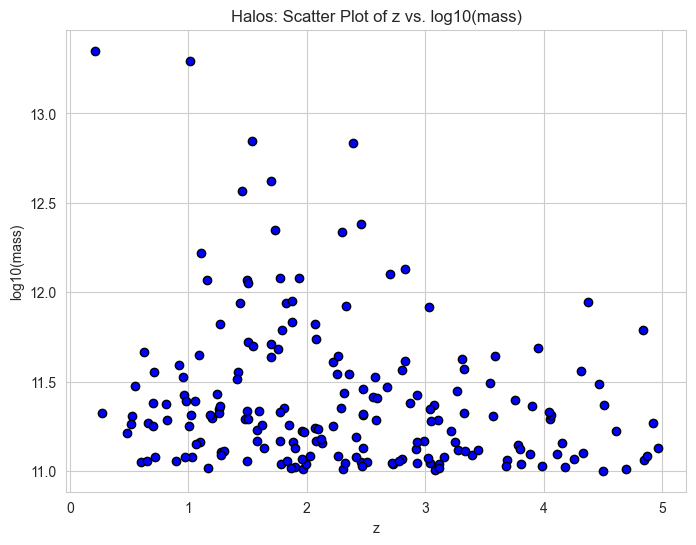

In [2]:
pipeline = HalosSkyPyPipeline(
    sky_area=0.00036,  # in square degrees
    m_max="1.0E+16",  # in solar masses
    m_min="1.0E+11",
    z_max=5.00,
)
halos = pipeline.halos
mass_sheet_correction = (
    pipeline.mass_sheet_correction
)  # calculating a negative convergence for
# mass sheet based on the average convergence of multiple halos rendering

print(halos)
z_halos = halos["z"]
mass_halos = halos["mass"]

log_mass = np.log10(mass_halos)
plt.figure(figsize=(8, 6))
plt.scatter(z_halos, log_mass, c="blue", marker="o", edgecolors="black")
plt.title("Halos: Scatter Plot of z vs. log10(mass)")
plt.xlabel("z")
plt.ylabel("log10(mass)")
plt.grid(True)

# Plotting the convergence map for the halos
## with or without mass sheet correction

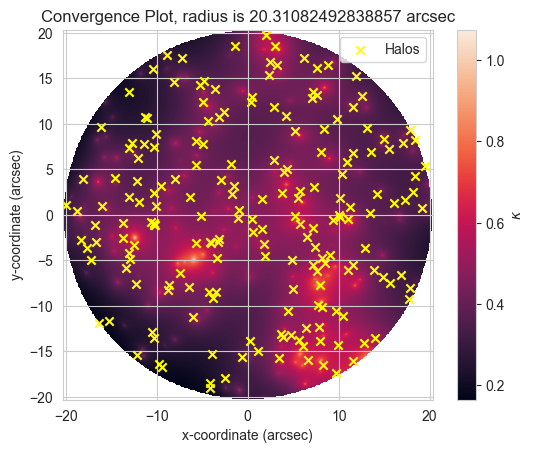

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Instantiate the HalosLens class with the halo list computed above and a defined sky area
halos_lens = HalosLensBase(
    halos_list=halos,
    mass_correction_list=mass_sheet_correction,
    mass_sheet=True,
    sky_area=0.0001,
    cosmo=cosmo,
)
halos_lens.plot_halos_convergence(
    diff=0.01,
)

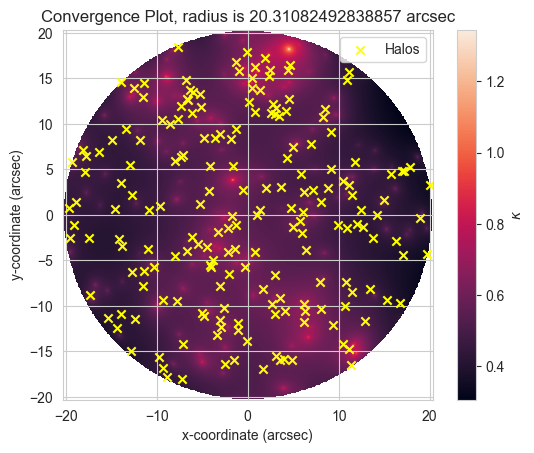

In [4]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Instantiate the HalosLens class with the halo list computed above and a defined sky area
halos_lens = HalosLensBase(
    halos_list=halos,
    mass_correction_list=None,  # No mass sheet correction
    mass_sheet=False,  # No mass sheet correction
    sky_area=0.0001,
    cosmo=cosmo,
)
halos_lens.plot_halos_convergence(diff=0.01)

## Render the joint contribution of external convergence and shears from halos rendering

In [5]:
halos_k, halos_g = run_halos_without_kde_by_multiprocessing(
    n_iterations=100,
    sky_area=0.00036,
    samples_number=100,
    cosmo=cosmo,
    z_max=5.0,
)

kappa_random_halos = convergence_mean_0(halos_k)
gamma_random_halos = halos_g

The 100 halo-lists took 13.715326309204102 seconds to run


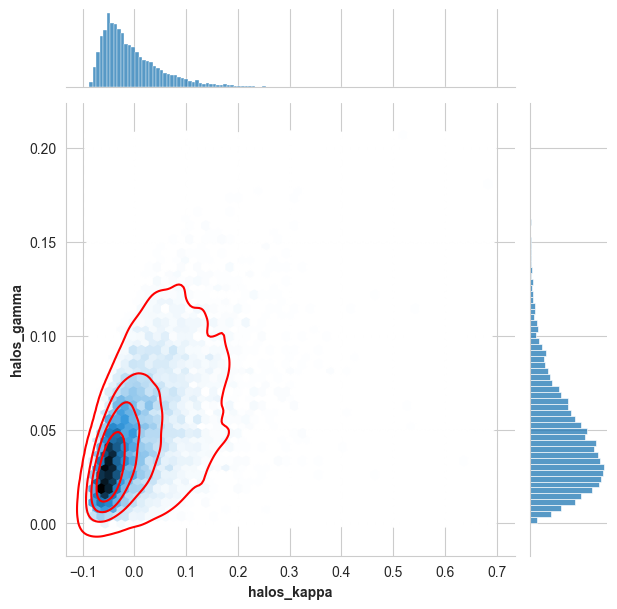

In [6]:
total_plot = sns.jointplot(x=kappa_random_halos, y=gamma_random_halos, kind="hex")
total_plot.plot_joint(sns.kdeplot, color="r", zorder=3, levels=5)
total_plot.ax_joint.set_xlabel("halos_kappa", fontweight="bold")
total_plot.ax_joint.set_ylabel("halos_gamma", fontweight="bold")
plt.show()

## Combine the halos and glass data

In [7]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
slsim_directory = os.path.dirname(parent_directory)
file_path = os.path.join(parent_directory, "tests/TestData/kgdata.npy")

In [8]:
kappa_values, gamma_values, nside = read_glass_data(file_name=file_path)
skyarea = skyarea_form_n(nside)
kappa_random_glass, gamma_random_glass = generate_samples_from_glass(
    kappa_values, gamma_values, n=5000
)
print(kappa_random_glass.shape, gamma_random_glass.shape)

(5000,) (5000,)


In [9]:
total_kappa, total_gamma = halos_plus_glass(
    kappa_random_glass, gamma_random_glass, kappa_random_halos, gamma_random_halos
)

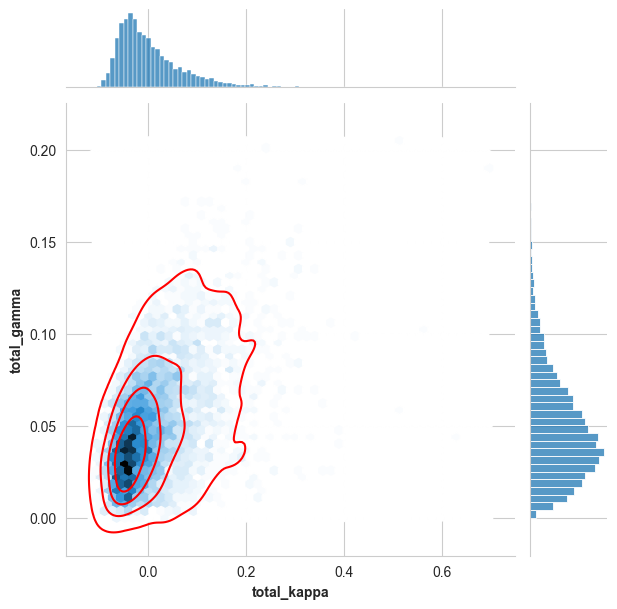

In [10]:
total_plot = sns.jointplot(x=total_kappa, y=total_gamma, kind="hex")
total_plot.plot_joint(sns.kdeplot, color="r", zorder=3, levels=5)
total_plot.ax_joint.set_xlabel("total_kappa", fontweight="bold")
total_plot.ax_joint.set_ylabel("total_gamma", fontweight="bold")
plt.show()

# Plotting the joint distribution of kappa and gamma
## with and without non-linear correction


The 300 halo-lists took 17.2766170501709 seconds to run
zs=1.5, zd=0.5,k_s_mean=-0.016847484598691495
The 300 halo-lists took 38.27841401100159 seconds to run
zs=1.5, zd=0.5,k_ext_mean=-0.016059205947899363
Variance of k_S: 0.000494052343945678
Variance of k_ext: 0.00044872681987004565


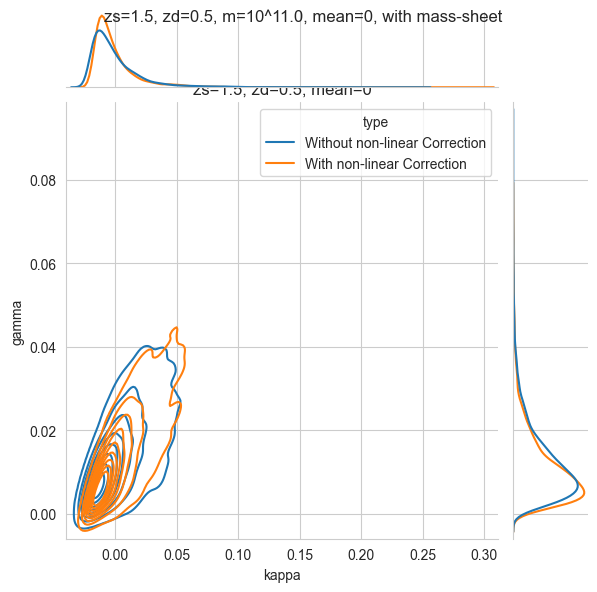

The 300 halo-lists took 32.73223114013672 seconds to run
zs=2.5, zd=0.5,k_s_mean=-0.006801728584460778
The 300 halo-lists took 78.62152695655823 seconds to run
zs=2.5, zd=0.5,k_ext_mean=-0.00897702671125577
Variance of k_S: 0.0018902917868368677
Variance of k_ext: 0.0011930105416473212


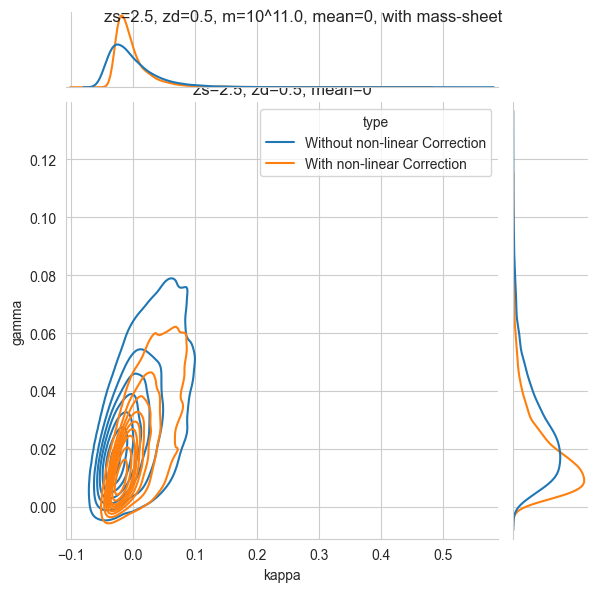

The 300 halo-lists took 11.82904601097107 seconds to run
zs=1.0, zd=0.5,k_s_mean=-0.012314191680922239
The 300 halo-lists took 24.441728830337524 seconds to run
zs=1.0, zd=0.5,k_ext_mean=-0.014023792924208061
Variance of k_S: 0.0001891244110086379
Variance of k_ext: 0.000378024920808079


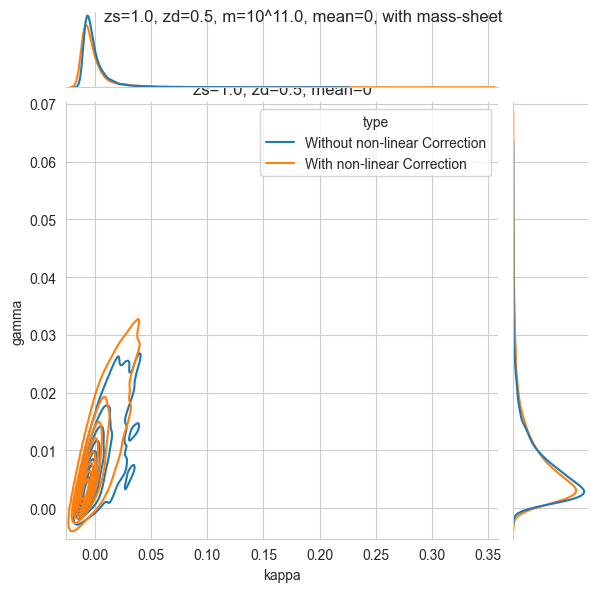

In [11]:
def plot_kappa_gamma(
    zs=1.5,
    zd=0.5,
    n_iterations=300,
    sky_area=0.00036,
    samples_number=30,
    m_min="1.0E+12",
    m_max="1.0E+16",
):
    # Setup Cosmology
    cosmo = default_cosmology.get()
    # Without Correction
    nk, ng = run_halos_without_kde_by_multiprocessing(
        n_iterations=n_iterations,
        sky_area=sky_area,
        samples_number=samples_number,
        cosmo=cosmo,
        m_min=m_min,
        m_max=m_max,
        z_max=zs,
        listmean=False,
    )
    nk_mean = sum(nk) / len(nk)
    print(f"zs={zs}, zd={zd},k_s_mean={nk_mean}")
    nk = convergence_mean_0(nk)

    # With Correction
    distribution = run_certain_redshift_lensext_kde_by_multiprocessing(
        n_iterations=n_iterations,
        sky_area=sky_area,
        samples_number=samples_number,
        cosmo=cosmo,
        m_min=m_min,
        m_max=m_max,
        z_max=zs,
        zs=zs,
        zd=zd,
        listmean=False,
    )
    nk1 = [point[0] for point in distribution]
    ng1 = [point[1] for point in distribution]
    nk1_mean = sum(nk1) / len(nk1)
    print(f"zs={zs}, zd={zd},k_ext_mean={nk1_mean}")
    nk1 = convergence_mean_0(nk1)

    # Combine Data for Joint KDE Plot
    df1 = pd.DataFrame({"x": nk, "y": ng, "type": "Without non-linear Correction"})
    df2 = pd.DataFrame({"x": nk1, "y": ng1, "type": "With non-linear Correction"})
    df_total = pd.concat([df1, df2], axis=0)

    var_nk = np.var(nk)
    var_nk1 = np.var(nk1)
    print(f"Variance of k_S: {var_nk}")
    print(f"Variance of k_ext: {var_nk1}")

    # Plotting
    plot = sns.jointplot(data=df_total, x="x", y="y", hue="type", kind="kde")

    plot.ax_joint.set_xlabel("kappa")
    plot.ax_joint.set_ylabel("gamma")
    m_min_float = float(m_min)
    plt.title(f"zs={zs}, zd={zd}, mean=0")
    plot.fig.suptitle(
        f"zs={zs}, zd={zd}, m=10^{np.log10(m_min_float)}, mean=0, with mass-sheet"
    )
    # plot.ax_joint.set_xlim(-0.2, 0.2)

    plt.show()


# To use the function:
plot_kappa_gamma(zs=1.5, zd=0.5, m_min="1.0E+11", m_max="1.0E+16")
plot_kappa_gamma(zs=2.5, zd=0.5, m_min="1.0E+11", m_max="1.0E+16")
plot_kappa_gamma(zs=1.0, zd=0.5, m_min="1.0E+11", m_max="1.0E+16")